# Analysing Emissions in Lebanon

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [28]:
import bokeh
from bokeh.layouts import column
from bokeh.models import Legend, Panel, Tabs

from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS

bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)
from bokeh.plotting import figure, show, output_notebook

In [29]:
from bokeh.plotting import ColumnDataSource
from bokeh.io import output_notebook
from bokeh.core.validation import silence
from bokeh.core.validation.warnings import EMPTY_LAYOUT

# Use the silence function to ignore the EMPTY_LAYOUT warning
silence(EMPTY_LAYOUT, True)


def get_line_chart(
    dataframe,
    title,
    source,
    subtitle=None,
    measure="measure",
    category="category",
    color_code=None,
):
    # Initialize the figure
    p2 = figure(
        x_axis_type="datetime", width=1000, height=400, toolbar_location="above"
    )
    p2.add_layout(Legend(), "right")

    # Define the color palette (make sure this has enough colors for the categories)
    color_palette = [
        "#4E79A7",  # Blue
        "#F28E2B",  # Orange
        "#E15759",  # Red
        "#76B7B2",  # Teal
        "#59A14F",  # Green
        "#EDC948",  # Yellow
        "#B07AA1",  # Purple
        "#FF9DA7",  # Pink
        "#9C755F",  # Brown
        "#BAB0AC",  # Gray
        "#7C7C7C",  # Dark gray
        "#6B4C9A",  # Violet
        "#D55E00",  # Orange-red
        "#CC61B0",  # Magenta
        "#0072B2",  # Bright blue
        "#329262",  # Peacock green
        "#9E5B5A",  # Brick red
        "#636363",  # Medium gray
        "#CD9C00",  # Gold
        "#5D69B1",  # Medium blue
    ]

    # Loop through each unique category and plot a bar
    for id, unique_category in enumerate(dataframe[category].unique()):
        # Filter the DataFrame for each category
        category_df = dataframe[dataframe[category] == unique_category].copy()
        category_df.sort_values(
            by="date", inplace=True
        )  # Ensure the DataFrame is sorted by date
        category_source = ColumnDataSource(category_df)

        # Plot the bars
        p2.line(
            x="date",
            y=measure,
            source=category_source,
            color=color_palette[id],
            legend_label=unique_category,
        )

    # Configure legend
    p2.legend.click_policy = "hide"
    p2.legend.location = "top_right"

    # Set the subtitle as the title of the plot if it exists
    if subtitle:
        p2.title.text = subtitle

    # Create title and subtitle text using separate figures
    title_fig = figure(title=title, toolbar_location=None, width=800, height=40)
    title_fig.title.align = "left"
    title_fig.title.text_font_size = "12pt"
    title_fig.border_fill_alpha = 0
    title_fig.outline_line_color = None

    sub_title_fig = figure(title=source, toolbar_location=None, width=800, height=40)
    sub_title_fig.title.align = "left"
    sub_title_fig.title.text_font_size = "10pt"
    sub_title_fig.title.text_font_style = "normal"
    sub_title_fig.border_fill_alpha = 0
    sub_title_fig.outline_line_color = None

    # Combine the title, plot, and subtitle into a single layout
    layout = column(title_fig, p2, sub_title_fig)

    return layout

In [54]:
edgar = pd.read_csv("../../data/air_pollution/n20_mean_emi_industry_adm2.csv")

In [43]:
shapefile_path = (
    "../../data/shapefiles/lbn_adm_cdr_20200810/lbn_admbnda_adm2_cdr_20200810.shp"
)
lebanon_adm2 = gpd.read_file(shapefile_path)

In [59]:
edgar_percapita_annual = pd.read_csv(
    "../../data/air_pollution/NH3-emissions-by-sector.csv"
)

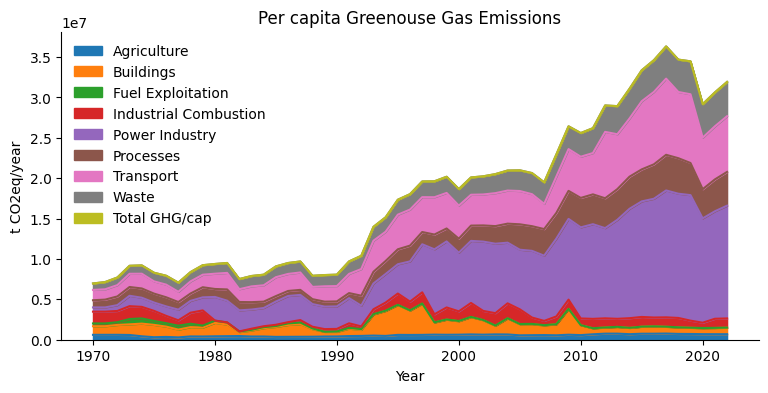

In [115]:
fig, ax = plt.subplots(figsize=(9, 4))

edgar_percapita_annual.set_index(["Category"]).plot(kind="area", ax=ax)
ax.set_title("Per capita Greenouse Gas Emissions")

ax.set_ylabel("t CO2eq/year")
ax.set_xlabel("Year")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.legend(frameon=False);

In [55]:
# Prepare the data

column_names = edgar.columns
column_names = [x[-4:] for x in column_names]
edgar.columns = column_names

edgar = edgar.set_index(["Name", "Pcod"]).stack().reset_index()

edgar.rename(
    columns={"level_2": "date", "Name": "admin2Name", 0: "n2o_industry"}, inplace=True
)
edgar["date"] = edgar["date"].astype(int)
edgar["date"] = pd.to_datetime(edgar["date"], format="%Y")
edgar = lebanon_adm2[["admin1Name", "admin2Name"]].merge(edgar)

In [57]:
output_notebook()
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

tabs = []

for adm in list(edgar["admin1Name"].unique()):
    df = edgar[edgar["admin1Name"] == adm]

    tabs.append(
        Panel(
            child=get_line_chart(
                df,
                "Annual N2O emissions at Admin 2",
                "Source: EDGAR",
                category="admin2Name",
                measure="n2o_industry",
            ),
            title=adm.capitalize(),
        )
    )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

In [86]:
import pandas as pd
import glob

# Step 1: List all text files
file_paths = glob.glob(
    "../../data/air_pollution/ENE_emi_txt/*.txt"
)  # Update the path and pattern as needed

dataframes = []

for file in file_paths:
    # Step 2: Read files into DataFrames and store them in a list
    df = pd.read_csv(file, delimiter=";", skiprows=2)
    df["year"] = file[57:61]
    dataframes.append(df)

# Step 3: Concatenate all DataFrames into one
emissions = pd.concat(dataframes, ignore_index=True)

# Now 'combined_dataframe' contains the data from all files

In [87]:
emissions["lat"] = emissions["lat"].astype(float)
emissions["lon"] = emissions["lon"].astype(float)

from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(emissions["lon"], emissions["lat"])]
gdf = gpd.GeoDataFrame(emissions, geometry=geometry)

In [98]:
power_industry_emissions = lebanon_adm2[["admin1Name", "admin2Name", "geometry"]].sjoin(
    gdf
)

c:\Users\sahit\anaconda3\envs\lebanon-economic-monitor\lib\site-packages\geopandas\geodataframe.py:2177: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


In [120]:
power_industry_emissions.rename(columns={"year": "date"}, inplace=True)

power_industry_emissions["date"] = power_industry_emissions["date"].astype(int)
power_industry_emissions["date"] = pd.to_datetime(
    power_industry_emissions["date"], format="%Y"
)

In [122]:
power_industry_emissions

,admin1Name,admin2Name,geometry,index_right,lat,lon,emission,date
5,Baalbek-El Hermel,Baalbek,"POLYGON ((36.50228 34.44826, 36.50239 34.44825...",453518,34.0,36.1,235887.0,2013-01-01
5,Baalbek-El Hermel,Baalbek,"POLYGON ((36.50228 34.44826, 36.50239 34.44825...",30867,34.0,36.1,39791.6,1973-01-01
5,Baalbek-El Hermel,Baalbek,"POLYGON ((36.50228 34.44826, 36.50239 34.44825...",79215,34.0,36.1,45379.8,1978-01-01
5,Baalbek-El Hermel,Baalbek,"POLYGON ((36.50228 34.44826, 36.50239 34.44825...",109101,34.0,36.1,82955.4,1981-01-01
5,Baalbek-El Hermel,Baalbek,"POLYGON ((36.50228 34.44826, 36.50239 34.44825...",7236,34.0,36.1,16186.4,1970-01-01
...,...,...,...,...,...,...,...,...
12,Bekaa,Zahle,"POLYGON ((35.91251 33.93292, 35.91373 33.93269...",559593,33.8,35.9,2380260.0,2021-01-01
12,Bekaa,Zahle,"POLYGON ((35.91251 33.93292, 35.91373 33.93269...",362431,33.8,35.9,797334.0,2005-01-01
12,Bekaa,Zahle,"POLYGON ((35.91251 33.93292, 35.91373 33.93269...",491217,33.8,35.9,2595680.0,2016-01-01
20,South,Saida,"POLYGON ((35.38770 33.58864, 35.38793 33.58863...",399773,33.4,35.3,48748.1,2009-01-01


In [124]:
output_notebook()
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

tabs = []

for adm in list(power_industry_emissions["admin1Name"].unique()):
    df = power_industry_emissions[power_industry_emissions["admin1Name"] == adm]

    tabs.append(
        Panel(
            child=get_line_chart(
                df[["admin2Name", "date", "emission"]],
                "Annual CO2 emissions at Admin 2 for Power Industry",
                "Source: EDGAR",
                category="admin2Name",
                measure="emission",
            ),
            title=adm.capitalize(),
        )
    )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...